In [78]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [79]:
df = pd.read_csv(r'C:\Users\dylan\Documents\Soccer Analytics\model_practice\cereal_rating.csv')

In [80]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [81]:
#One Hot-Encode Hot and Cold
df['cold'] = np.where(df.type=='C', 1, 0)

In [82]:
nums = df.loc[:, (df.dtypes == np.float64) | (df.dtypes == np.int64)]
nums.describe()

,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


We can see right off the bat that the distribution spread of vitamins and weight are near zero with their 1st and 3rd quartiles having the same value. Hence we will not need to view their distribution plots.

In [83]:
nums = nums.drop(['weight', 'vitamins'], axis = 1)

In [84]:
def dist_plots(cols, x_size=12, y_size=2):
    figure, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(x_size, y_size))
    y = 0
    for col in cols:
        sns.distplot(df[col], ax=axes[y], bins=int(np.sqrt(len(df[col]))))
        axes[y].set_ylabel('Count')
        axes[y].set_xlabel(col.title())
        y+=1
    figure.tight_layout()
    plt.show()

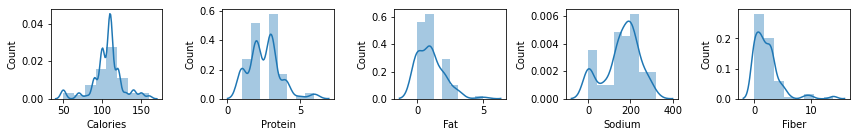

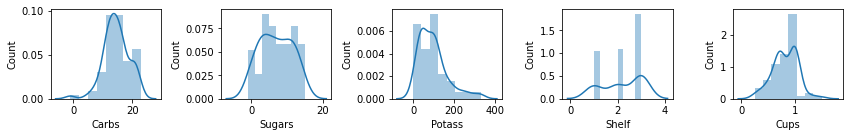

In [85]:
dist_plots(['calories', 'protein', 'fat', 'sodium', 'fiber'])
dist_plots(['carbs', 'sugars','potass', 'shelf', 'cups'])

Calories, carbs, sugars, and potass appear to follow relatively normal distributions while shelf has so few observiations in its distribution we could potentially consider it a nominal variable.

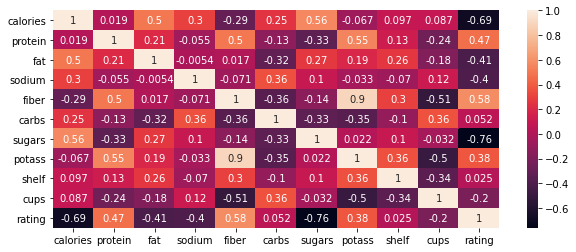

In [86]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(nums.corr(), annot=True)
plt.show()

From the heatmap we can tell that both calories and sugars have a high negative linear correlation with cereal rating. Indicating that higher calorie count and amounts of sugar are both associated with lower cereal ratings. This can also be seen by looking at the positive correlation between calories and sugars amount. With more sugar comes a higher amount of calories.
<br><br>
Conversely, higher fiber counts are associated with higher cereal ratings. While higher amounts of protein can also be associated with higher amounts of potassium.

In [87]:
obs = df.loc[:, df.dtypes == object]
obs.describe().transpose()

,count,unique,top,freq
name,77,77,Almond Delight,1
mfr,77,7,K,23
type,77,2,C,74


Let's dive deeper in cereal manufacturers by looking at the distribution of each distributor as well as average cereal ratings and calories per manufacturer.

In [88]:
#create a function to label and annotate our graphs
def generate_text(df, axes, y_val, deci=0, weight=None):
    for index, row in df.iterrows():
        axes.text(row.name,row[y_val], round(row[y_val], deci), color='black', ha='center', weight=weight)

Generate value counts and column averages of cereal manufacturer.

In [89]:
#percenatage of value count
perc = df.mfr.value_counts(normalize=True).sort_index().reset_index()
#avg rating and calorie count by manufacturer
mfg_avgs = df.groupby('mfr', as_index=False).agg({'rating':'mean', 'calories':'mean'})

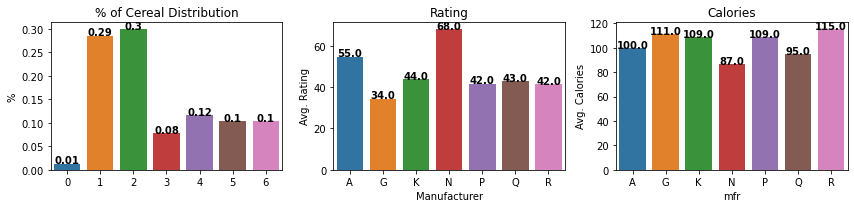

In [90]:
figure, axes = plt.subplots(nrows=1, ncols = 3, figsize=(12, 3))

#plot % distribution
sns.barplot(perc.index, perc.mfr, ax=axes[0])
axes[0].set_title('% of Cereal Distribution')
axes[0].set_ylabel('%')
#label manufacturer
generate_text(perc, axes[0], 'mfr', deci=2, weight='bold')

#plot avg rating
sns.barplot(mfg_avgs.mfr, mfg_avgs.rating, ax =axes[1])
axes[1].set_title('Rating')
axes[1].set_xlabel('Manufacturer')
axes[1].set_ylabel('Avg. Rating')
#label rating
generate_text(mfg_avgs, axes[1], 'rating', deci=0, weight='bold')

#plot avg calories
sns.barplot(mfg_avgs.mfr, mfg_avgs.calories, ax =axes[2])
axes[2].set_title('Calories')
axes[2].set_ylabel('Avg. Calories')
#label calories
generate_text(mfg_avgs, axes[2], 'calories', deci=0, weight='bold')
figure.tight_layout()
plt.show()

Manufacturer's G and K are the most prevalent manufacturers while A and N have the highest average rating's amongst our dataset. Manufacturer G has the 2nd highest number of cereals, but the lowest average rating. Manufacturer N has the highest average rating and the lowest calories on average across their brands of cereal.

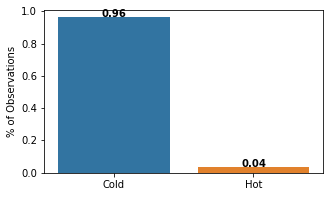

In [91]:
types = pd.DataFrame(df.type.value_counts(normalize=True)).reset_index()

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(types.index, types.type)
ax.set_xticklabels(['Cold', 'Hot'])
ax.set_ylabel('% of Observations')

generate_text(types, ax, 'type', deci=2, weight='bold')
plt.show()

96% of our observation are of the cold cereal type with the other 4% being cereal that is served hot.

Our main variable of interest in this dataset is cereal rating. We will take a deeper dive looking at the distribution via histogram and by generating an empirical distribution of cereal rating.

In [95]:
#Function to view histogram and empirical distribution of array
def hist_ecdf(array, label):
    #plot histogram
    figure, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10, 3))
    axes[0].hist(array, bins=10)
    axes[0].set_xlabel(label)
    axes[0].set_title('Histogram')
    axes[0].vlines(np.mean(array), ymin=0, ymax=25, color='red', label='Mean')
    axes[0].vlines(np.median(array), ymin=0, ymax=25, color='purple', label='Median')
    axes[0].legend()
    
    #sort array
    x = np.sort(array)
    #create evenly spaced array of same length
    y = np.arange(1, len(x)+1) / len(x)

    #Create theoretical normal distribution to check if data is normal
    nu = x.mean()
    sig = x.std()
    #Generate a normal distribution using the mean and std from our array
    samples = np.random.normal(nu, sig, 10000)
    x_theor = np.sort(samples)
    y_theor = np.arange(1, len(samples)+1) / len(samples)

    #Plot to compare actual vs theoretical
    axes[1].plot(x, y, marker='.', linestyle='none', color='blue')
    axes[1].plot(x_theor, y_theor, color='black')
    axes[1].vlines(np.mean(array), ymin=0, ymax=1, color='red', label='Mean')
    axes[1].vlines(np.median(array), ymin=0, ymax=1, color='purple', label='Median')
    axes[1].set_title('Empirical Cumulative Distribution Function')
    axes[1].set_ylabel('ECDF')
    axes[1].set_xlabel(label)
    axes[1].legend()
    plt.show()

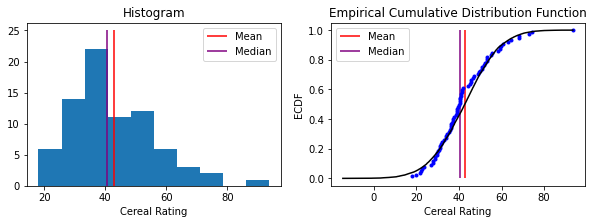

In [96]:
hist_ecdf(df.rating.values, 'Cereal Rating')

The mean of our cereal ratings is greater than the median value, taking this into consideration while looking at the histrogram we can say our data is skewed right. The ECDF of the data confirms our suspicion that the data doesn't follow a truly normal distribution. We will try using log cereal rating as our value.

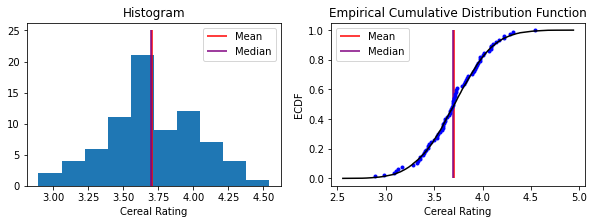

In [97]:
hist_ecdf(np.log(df.rating.values), 'Cereal Rating')

After taking the log of our values we can now see our data follows a nomal distribution far more closely. For regression purposes we should take the log of rating to fit the normality assumption of the model.

In [98]:
#create dummies for manufacturer
df = pd.get_dummies(df, columns=['mfr'], drop_first=True)

In [99]:
y = np.log(df['rating'])
X = df.drop(['rating', 'name', 'type'], axis = 1)

Start by calculating the VIF of our predictors to find any high correlation between them.

In [100]:
#Calculate VIF for each predictor
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif.sort_values('vif', ascending=False).head()

,features,vif
0,calories,417.253345
10,weight,274.251366
5,carbs,117.615085
12,cold,85.741864
14,mfr_K,52.077644


We can see that some of our variables are very highly correlated with massive variance inflation values. Let's remove from consideration until we find a safe VIF of under 10.

In [101]:
#remove columns until vif < 10
while vif['vif'].max() > 10:
    X = X.drop(vif.loc[vif.vif==vif.vif.max(), 'features'], axis = 1)
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(X.values, k) for k in range(len(X.columns))]
    vif['features'] = X.columns
vif

,vif,features
0,9.105466,protein
1,3.354436,fat
2,8.164265,sodium
3,2.773503,fiber
4,5.350216,sugars
5,3.280394,vitamins
6,7.565189,mfr_G
7,7.579315,mfr_K
8,1.735977,mfr_N
9,3.288454,mfr_P


In [112]:
#split our data into a training set and a hold out set to evaluate after grid search cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

Linear Regression

In [113]:
linreg = LinearRegression()

rsq_reg = round(cross_val_score(linreg, X_train, y_train, cv=10).mean(), 10)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
rmse_reg = MSE(y_test, y_pred)**(1/2)

Ridge Regression

In [114]:
ridge = Ridge()
param_grid = {'alpha':np.arange(0.5, 20.1, 0.1)}

ridge_cv = GridSearchCV(ridge, param_grid, cv = 5)
ridge_cv.fit(X_train, y_train)
alph = ridge_cv.best_params_['alpha']
print(f"Alpha Parameter: {alph}")

rsq_ridge = round(cross_val_score(ridge_cv.best_estimator_, X_test, y_test, cv = 5).mean(), 3)
ridge_cv.best_estimator_.fit(X_train, y_train)
y_pred = ridge_cv.best_estimator_.predict(X_test)
rmse_ridge = MSE(y_test, y_pred)**(1/2)

Alpha Parameter: 3.999999999999999


In [115]:
ridge_cv.best_score_

0.8278541663182312

Decision Tree

In [106]:
tree = DecisionTreeRegressor(random_state=142)
param_grid = {'criterion':['mse', 'friedman_mse', 'mae'],
             'max_depth':np.arange(1, 30)}

tree_cv = GridSearchCV(tree, param_grid, cv = 5)
tree_cv.fit(X_train, y_train)
crit, max_d = tree_cv.best_params_.values()
print(f"Criteria: {crit} | Max Depth: {max_d}")

rsq_tree = round(cross_val_score(tree_cv.best_estimator_, X_test, y_test, cv = 5).mean(), 3)
tree_cv.best_estimator_.fit(X_train, y_train)
y_pred = tree_cv.best_estimator_.predict(X_test)
rmse_tree = MSE(y_test, y_pred)**(1/2)

Criteria: friedman_mse | Max Depth: 5


In [107]:
tree_cv.best_score_

0.7075993052353072

Random Forest

In [108]:
rf = RandomForestRegressor(random_state=142)
param_grid = {'n_estimators': [100, 500, 750, 1000],
             'max_features': ['auto', 'sqrt'],
             'bootstrap': [True, False]}

rf_cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)
boot, max_f, n_est = rf_cv.best_params_.values()
print(f"Estimators: {n_est} | Max Features: {max_f} | Bootsrapping: {boot}")

rsq_rf = round(cross_val_score(rf_cv.best_estimator_, X_test, y_test, cv = 5).mean(), 3)
rf_cv.best_estimator_.fit(X_train, y_train)
y_pred = rf_cv.best_estimator_.predict(X_test)
rmse_rf = MSE(y_test, y_pred)**(1/2)

Estimators: 1000 | Max Features: sqrt | Bootsrapping: False


In [109]:
rf_cv.best_score_

0.8296238181115276

In [110]:
print('Linear Regression: R-SQ = {} | RMSE = {}'.format(rsq_reg, rmse_reg))
print('Ridge Regression: R-SQ = {} | RMSE = {}'.format(rsq_ridge, rmse_ridge))
print('Decision Tree: R-SQ = {} | RMSE = {}'.format(rsq_tree, rmse_tree))
print('Random Forest: R-SQ = {} | RMSE = {}'.format(rsq_rf, rmse_rf))

Linear Regression: R-SQ = 0.8245242556 | RMSE = 0.09409287869177067
Ridge Regression: R-SQ = 0.798 | RMSE = 0.09103091006554855
Decision Tree: R-SQ = 0.416 | RMSE = 0.20460196066652095
Random Forest: R-SQ = 0.463 | RMSE = 0.13640868724695906


The ridge regression provides the second highest r-sq after the linear regression but has the lowest rmse. taking this into consideration we would select this as our model moving forward.

In [141]:
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {round(ridge_cv.best_estimator_.coef_[i], 5)}")

protein: 0.05264
fat: -0.08835
sodium: -0.00111
fiber: 0.0542
sugars: -0.03861
vitamins: -3e-05
mfr_G: -0.01118
mfr_K: 0.02163
mfr_N: -0.00562
mfr_P: 0.01829
mfr_Q: -0.05674
mfr_R: 0.03362


From looking at the coefficients we can determine that protein, fiber, mfr_K, mfr_P, and mfr_R all have positive linear coefficents with respect to cereal rating while fat, sodium, sugars, vitamins, mfr_G, mfr_N, and mfr_Q all have negative coefficients. We can read these as for every 1g increase in protein we can expect a 0.05264 increase in cereal rating.